In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

def trend(time, slope=0):
    """
    Generates synthetic data that follows a straight line given a slope value.

    Args:
      time (array of int) - contains the time steps
      slope (float) - determines the direction and steepness of the line

    Returns:
      series (array of float) - measurements that follow a straight line
    """

    # Compute the linear series given the slope
    series = slope * time

    return series

def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern, you can change it if you wish
    
    Args:
      season_time (array of float) - contains the measurements per time step

    Returns:
      data_pattern (array of float) -  contains revised measurement values according 
                                  to the defined pattern
    """

    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))
    
    return data_pattern

def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period

    Args:
      time (array of int) - contains the time steps
      period (int) - number of time steps before the pattern repeats
      amplitude (int) - peak measured value in a period
      phase (int) - number of time steps to shift the measured values

    Returns:
      data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """
    
    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern

def noise(time, noise_level=1, seed=None):
    """Generates a normally distributed noisy signal

    Args:
      time (array of int) - contains the time steps
      noise_level (float) - scaling factor for the generated signal
      seed (int) - number generator seed for repeatability

    Returns:
      noise (array of float) - the noisy signal
    """

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level
    
    return noise

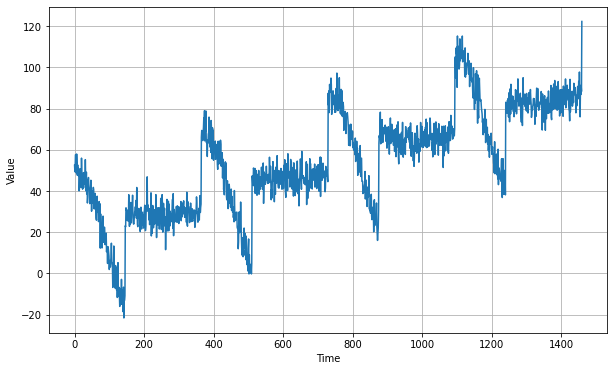

In [3]:
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)

In [4]:
# Define the split time
split_time = 1000

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

In [5]:
# Parameters
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [7]:
# Generate the dataset windows
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [8]:
# Print shapes of feature and label
for window in dataset.take(1):
  print(f'shape of feature: {window[0].shape}')
  print(f'shape of label: {window[1].shape}')

shape of feature: (32, 20)
shape of label: (32,)


<h2>Build the Model</h2>

In [10]:
model_tune = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[window_size]),
    tf.keras.layers.SimpleRNN(40, return_sequences=True), 
    tf.keras.layers.SimpleRNN(40),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

In [11]:
model_tune.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 20, 1)             0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 20, 40)            1680      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 40)                3240      
                                                                 
 dense (Dense)               (None, 1)                 41        
                                                                 
 lambda_1 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 4,961
Trainable params: 4,961
Non-trainable params: 0
_________________________________________________________________


In [12]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch/20)
)

optimizer = tf.keras.optimizers.SGD(momentum=0.9)

model_tune.compile(loss=tf.keras.losses.Huber(), optimizer = optimizer)

history = model_tune.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 4s 36ms/step - loss: 29.2958 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 1s 17ms/step - loss: 28.6175 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 1s 15ms/step - loss: 27.8785 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 1s 16ms/step - loss: 27.1297 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 1s 18ms/step - loss: 26.3910 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 1s 17ms/step - loss: 25.7045 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 1s 16ms/step - loss: 25.0387 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 1s 17ms/step - loss: 24.4402 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 1s 16ms/step - loss: 23.8644 - lr: 2.5119e-08
Epoch 10/100
31/31 [==============================] - 1s 17ms/step - loss: 23.3086 - lr: 2.8184e-08
Epoch 11/

(1e-08, 0.001, 0.0, 50.0)

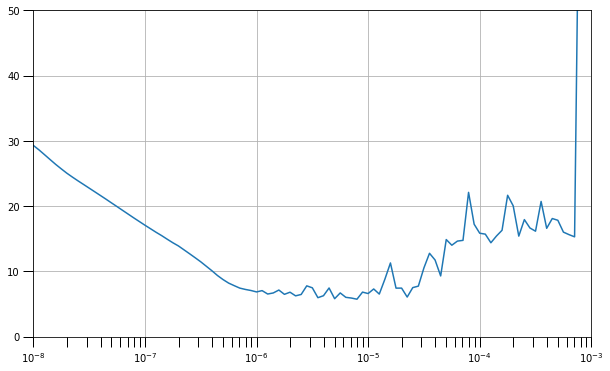

In [13]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 50])

(1e-07, 0.0001, 0.0, 20.0)

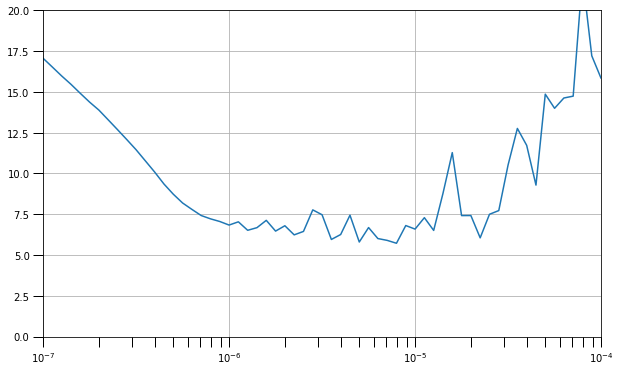

In [14]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-7, 1e-4, 0, 20])

In [15]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[window_size]),
    tf.keras.layers.SimpleRNN(40, return_sequences=True), 
    tf.keras.layers.SimpleRNN(40),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

learning_rate = 1e-6


optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(), optimizer = optimizer)

history = model.fit(dataset, epochs=100)


Epoch 1/100
31/31 [==============================] - 2s 10ms/step - loss: 59.3426
Epoch 2/100
31/31 [==============================] - 0s 10ms/step - loss: 14.4093
Epoch 3/100
31/31 [==============================] - 0s 10ms/step - loss: 11.6442
Epoch 4/100
31/31 [==============================] - 0s 10ms/step - loss: 10.0617
Epoch 5/100
31/31 [==============================] - 0s 9ms/step - loss: 8.5316
Epoch 6/100
31/31 [==============================] - 0s 10ms/step - loss: 7.6410
Epoch 7/100
31/31 [==============================] - 0s 9ms/step - loss: 7.2845
Epoch 8/100
31/31 [==============================] - 0s 9ms/step - loss: 7.3134
Epoch 9/100
31/31 [==============================] - 0s 9ms/step - loss: 7.2280
Epoch 10/100
31/31 [==============================] - 0s 9ms/step - loss: 6.9225
Epoch 11/100
31/31 [==============================] - 0s 10ms/step - loss: 6.6092
Epoch 12/100
31/31 [==============================] - 0s 9ms/step - loss: 6.7330
Epoch 13/100
31/31 [=======

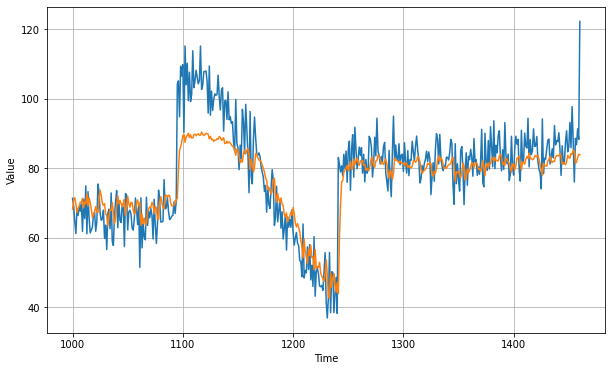

In [16]:
# Initialize a list
forecast = []

# Reduce the original series
forecast_series = series[split_time - window_size:]

# Use the model to predict data points per window size
for time in range(len(forecast_series) - window_size):
  forecast.append(model.predict(forecast_series[time:time + window_size][np.newaxis]))

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [17]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

In [ ]:
# Reduce the original series
forecast_series = series[split_time - window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [18]:

print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

67.3988
6.047566


https://en.wikipedia.org/wiki/Huber_loss